In [13]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F

import io
import evo
import evo.main_ape as main_ape
import evo.main_rpe as main_rpe

from tqdm import tqdm
from evo.core.metrics import PoseRelation, Unit
from evo.core.trajectory import PoseTrajectory3D
from evo.core import lie_algebra
from evo.tools.plot import PlotMode
from copy import deepcopy
from scipy.spatial.transform import Rotation
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map
from vggt.utils.helper import create_pixel_coordinate_grid, randomly_limit_trues
from vggt.dependency.track_predict import predict_tracks
from vggt.dependency.np_to_pycolmap import batch_np_matrix_to_pycolmap, batch_np_matrix_to_pycolmap_wo_track

from utils.umeyama import umeyama
from utils.cam_viz import create_interactive_camera_animation

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
def eval_trajectory(poses_est, poses_gt, frame_ids, align=False):

    traj_ref = PoseTrajectory3D(
        positions_xyz=poses_gt[:, :3, 3],
        orientations_quat_wxyz=Rotation.from_matrix(poses_gt[:, :3, :3]).as_quat(scalar_first=True),
        timestamps=frame_ids)
    traj_est = PoseTrajectory3D(
        positions_xyz=poses_est[:, :3, 3],
        orientations_quat_wxyz=Rotation.from_matrix(poses_est[:, :3, :3]).as_quat(scalar_first=True),
        timestamps=frame_ids)

    ate_result = main_ape.ape(
        deepcopy(traj_ref),
        deepcopy(traj_est),
        est_name="traj",
        pose_relation=PoseRelation.translation_part,
        align=align,
        align_origin=align,
        correct_scale=align)
    ate = ate_result.stats["rmse"]

    are_result = main_ape.ape(
        deepcopy(traj_ref),
        deepcopy(traj_est),
        est_name="traj",
        pose_relation=PoseRelation.rotation_angle_deg,
        align=align,
        align_origin=align,
        correct_scale=align)
    are = are_result.stats["rmse"]

    # RPE rotation and translation
    rpe_rots_result = main_rpe.rpe(
        deepcopy(traj_ref),
        deepcopy(traj_est),
        est_name="traj",
        pose_relation=PoseRelation.rotation_angle_deg,
        align=align,
        align_origin=align,
        correct_scale=align,
        delta=1,
        delta_unit=Unit.frames,
        rel_delta_tol=0.01,
        all_pairs=True)
    rpe_rot = rpe_rots_result.stats["rmse"]

    rpe_transs_result = main_rpe.rpe(
        deepcopy(traj_ref),
        deepcopy(traj_est),
        est_name="traj",
        pose_relation=PoseRelation.translation_part,
        align=align,
        align_origin=align,
        correct_scale=align,
        delta=1,
        delta_unit=Unit.frames,
        rel_delta_tol=0.01,
        all_pairs=True)
    rpe_trans = rpe_transs_result.stats["rmse"]

    plot_mode = PlotMode.xz
    fig = plt.figure()
    ax = evo.tools.plot.prepare_axis(fig, plot_mode)
    ax.set_title(f"ATE: {round(ate, 3)}, ARE: {round(are, 3)}")
    evo.tools.plot.traj(ax, plot_mode, traj_ref, "--", "gray", "gt")
    evo.tools.plot.traj_colormap(
        ax,
        traj_est,
        ate_result.np_arrays["error_array"],
        plot_mode,
        min_map=ate_result.stats["min"],
        max_map=ate_result.stats["max"],
    )
    ax.legend()

    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=90)
    buffer.seek(0)

    pillow_image = Image.open(buffer)
    pillow_image.load()
    buffer.close()
    plt.close(fig)

    return {
        "ate": ate,
        "are": are,
        "rpe_rot": rpe_rot,
        "rpe_trans": rpe_trans
    }, pillow_image

def run_VGGT(model, images, dtype, resolution=518):
    # images: [B, 3, H, W]

    assert len(images.shape) == 4
    assert images.shape[1] == 3

    device = next(model.parameters()).device
    images = images.to(device)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images = images[None]  # add batch dimension
            valid_layers = model.depth_head.intermediate_layer_idx
            if valid_layers[-1] != model.aggregator.aa_block_num - 1:
                valid_layers.append(model.aggregator.aa_block_num - 1)
            aggregated_tokens_list, ps_idx = model.aggregator(images, valid_layers)
            aggregated_tokens_list = [tokens.to(device) if tokens is not None else None for tokens in aggregated_tokens_list]

        # Predict Cameras
        pose_enc = model.camera_head(aggregated_tokens_list)[-1]
        # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])
        # Predict Depth Maps
        depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    extrinsic = extrinsic.squeeze(0).cpu().numpy()
    intrinsic = intrinsic.squeeze(0).cpu().numpy()
    depth_map = depth_map.squeeze(0).cpu().numpy()
    depth_conf = depth_conf.squeeze(0).cpu().numpy()
    return extrinsic, intrinsic, depth_map, depth_conf

def maximum_weight_connected_subtree(G, k, iter=200, remove_deg_thresh=50):
    """
    Find a connected subtree with k nodes that has the maximum total edge weight.
    This is an approximate heuristic using tools from networkx.
    """
    best_tree = None
    best_weight = float('-inf')

    # Get top 200 nodes with highest degree
    degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)
    top_nodes = [node for node, _ in degree_list[:iter]]

    # Remove nodes with degree less than remove_deg_thresh to accelerate the search
    G_copy = G.copy()
    edges_to_remove = [(u, v) for u, v, d in G_copy.edges(data=True) if d['weight'] < remove_deg_thresh]
    G_copy.remove_edges_from(edges_to_remove)
    print(f"Removed {len(edges_to_remove)} edges with weight less than {remove_deg_thresh}.")

    for start_node in tqdm(top_nodes, desc="Finding maximum weight connected subtree"):
        nodes = set([start_node])

        # Iteratively add the neighbor with the maximum edge weight
        while len(nodes) < k:
            # Find all boundary edges connecting current nodes to external nodes
            boundary_edges = [
                (u, v, d['weight'])
                for u in nodes
                for v, d in G_copy[u].items()
                if v not in nodes
            ]
            if not boundary_edges:
                break
            # Select the edge with the maximum weight
            u, v, w = max(boundary_edges, key=lambda x: x[2])
            nodes.add(v)

        if len(nodes) < k:
            continue

        # Construct the maximum spanning tree from the selected nodes
        subgraph = G_copy.subgraph(nodes)
        # mst = nx.maximum_spanning_tree(subgraph, weight='weight')
        total_weight = subgraph.size(weight='weight')

        if total_weight > best_weight:
            best_weight = total_weight
            best_tree = subgraph

    return best_tree, best_weight


In [3]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model.eval()

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [4]:
import utils.colmap as colmap_utils

# Get image paths and preprocess them
data_dir = "../data/MipNeRF360/bonsai"
sparse_dir_gt = os.path.join(data_dir, "sparse", "0")
dust_dir = os.path.join(data_dir, "mast3r")
images_dir = os.path.join(data_dir, "images")

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))
# images_gt = dict(sorted(images_gt.items(), key=lambda item: item[0]))

# sparse_dir_pred = "../data/MipNeRF360_vggt/bicycle/sparse/0"
# cameras_pred = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_pred, "cameras.bin"))
# images_pred = colmap_utils.read_images_binary(os.path.join(sparse_dir_pred, "images.bin"))
# pcd_pred = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_pred, "points3D.bin"))
# images_pred = dict(sorted(images_pred.items(), key=lambda item: item[0]))

In [5]:
images_gt_updated = {id: images_gt[id] for id in list(images_gt.keys())}
image_path_list = [os.path.join(images_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]
total_frame_num = len(image_path_list)

vggt_fixed_resolution = 518
images, original_coords = load_and_preprocess_images_ratio(image_path_list, vggt_fixed_resolution)

# plot images
# plt.figure(figsize=(16, 10))
# for i, img in enumerate(images):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(img.permute(1, 2, 0).cpu().numpy())
#     plt.title(base_image_path_list[i].split('_Zenmuse')[0])
#     plt.axis('off')

In [6]:
# Run VGGT to estimate camera and depth
# Run with 518x518 images
torch.cuda.empty_cache()
extrinsic, intrinsic, depth_map, depth_conf = run_VGGT(model, images, dtype, vggt_fixed_resolution)
points_3d = unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic)

In [7]:
ANALYZE_PROJECTION = False

if ANALYZE_PROJECTION:

    k = random.choice(range(len(images_gt_updated)))
    idx = list(images_gt_updated.keys())[k]

    point3D_ids_gt = images_gt_updated[idx].point3D_ids
    mask_gt = point3D_ids_gt >= 0
    xys_gt = images_gt_updated[idx].xys[mask_gt]
    pcd_rgb_gt = np.stack([pcd_gt[id].rgb for id in point3D_ids_gt[mask_gt]], axis=0)
    pcd_xyz_gt = np.stack([pcd_gt[id].xyz for id in point3D_ids_gt[mask_gt]], axis=0)

    # transform xys_gt to the coordinate on points_3d, which is (N, H, W, 3)
    xys_gt_scaled = np.zeros_like(xys_gt)
    pcd_xyz_sampled = np.zeros_like(pcd_xyz_gt)
    pcd_conf_sampled = np.zeros_like(pcd_rgb_gt[:, 0])  # Assuming confidence is a single channel
    pcd_rgb_sampled = np.zeros_like(pcd_rgb_gt)
    resize_ratio = original_coords[:, -2:].max() / vggt_fixed_resolution

    xys_gt_scaled[:, 0] = xys_gt[:, 0] / resize_ratio + original_coords[k, 0]
    xys_gt_scaled[:, 1] = xys_gt[:, 1] / resize_ratio + original_coords[k, 1]
    xys_gt_scaled = np.clip(xys_gt_scaled, 0, vggt_fixed_resolution - 1).astype(int)
    pcd_xyz_sampled = points_3d[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_conf_sampled = depth_conf[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_rgb_sampled = images[k, :, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)].permute(1, 0).cpu().numpy() * 255

    image = cv2.imread(os.path.join(images_dir, images_gt_updated[idx].name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_project = np.zeros_like(image)

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"GT Image of {images_gt_updated[idx].id}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image_project)
    plt.scatter(xys_gt[:, 0], xys_gt[:, 1], c=pcd_rgb_gt / 255.0, s=1)
    plt.title("GT Points")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image_project)
    plt.scatter(xys_gt[:, 0], xys_gt[:, 1], c=pcd_rgb_sampled / 255.0, s=1)
    plt.title("Sampled Points")
    plt.axis('off')

In [8]:
from utils.metric_torch import camera_to_rel_deg, calculate_auc_np

fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

# gt w2c
gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)
# pred_se3[:, :3, :3] = rotation_pred
# pred_se3[:, 3, :3] = translation_pred

# add alignment
camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
camera_centers_pred = - (pred_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
c, R, t = umeyama(camera_centers_gt.T, camera_centers_pred.T)
camera_centers_gt_aligned = (c * (R @ camera_centers_gt.T) + t).T
print("    --  Umeyama Scale: ", c)
print("    --  Umeyama Rotation: \n", R)
print("    --  Umeyama Translation: \n", t)

ext_transform = np.eye(4)
ext_transform[:3, :3] = R
ext_transform[:3, 3:] = t
ext_transform = np.linalg.inv(ext_transform)

gt_aligned = np.zeros((extrinsic.shape[0], 4, 4))
gt_aligned[:, :3, :3] = gt_se3[:, :3, :3].cpu().numpy()
gt_aligned[:, :3, 3] = gt_se3[:, 3, :3].cpu().numpy() * c
gt_aligned[:, 3, 3] = 1.0
gt_aligned = np.einsum('bmn,bnk->bmk', gt_aligned, ext_transform[None])

gt_se3_aligned = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3_aligned[:, :3, :3] = torch.tensor(gt_aligned[:, :3, :3], device=device)
gt_se3_aligned[:, 3, :3] = torch.tensor(gt_aligned[:, :3, 3], device=device)

rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(pred_se3, gt_se3_aligned, device, 4)
print(f"    --  Pair Rot   Error (Deg) of Vanilla: {rel_rangle_deg.mean():10.2f}")
print(f"    --  Pair Trans Error (Deg) of Vanilla: {rel_tangle_deg.mean():10.2f}")

rError = rel_rangle_deg.cpu().numpy()
tError = rel_tangle_deg.cpu().numpy()

Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
print(f"    --  AUC at 30: {Auc_30:.4f}")

/tmp/ipykernel_13465/2102632063.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)


    --  Umeyama Scale:  0.1286321755249738
    --  Umeyama Rotation: 
 [[ 0.45210756  0.64201917 -0.61920117]
 [-0.2451966   0.75691172  0.605775  ]
 [ 0.85759981 -0.12204945  0.49962644]]
    --  Umeyama Translation: 
 [[ 0.0348455 ]
 [-0.29861492]
 [ 0.46608338]]
    --  Pair Rot   Error (Deg) of Vanilla:       1.58
    --  Pair Trans Error (Deg) of Vanilla:       2.40
    --  AUC at 30: 0.9239


In [ ]:
start_idx, end_idx = 0, total_frame_num

fig = create_interactive_camera_animation(
    poses_over_time=pred_se3[None].permute(0, 1, 3, 2),
    gt_poses=gt_se3_aligned.permute(0, 2, 1),
    save_path='camera_optimization.html',
    depth=0.1,
)

variance = np.var(camera_centers_pred, axis=0)
ground_plane_indices = np.argsort(variance)[1:]

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(camera_centers_gt_aligned[start_idx:end_idx, ground_plane_indices[0]], camera_centers_gt_aligned[start_idx:end_idx, ground_plane_indices[1]], c='blue', label='Camera Centers GT')
plt.scatter(camera_centers_pred[start_idx:end_idx, ground_plane_indices[0]], camera_centers_pred[start_idx:end_idx, ground_plane_indices[1]], c='red', label='Camera Centers Predicted')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()

In [10]:
camtoworlds_train = np.load(os.path.join(dust_dir, 'camera_poses.npy'))
camtoworlds_train_gt = np.load(os.path.join(data_dir, 'pose_gt_train.npy'))

mast3r_se3 = torch.tensor(np.linalg.inv(camtoworlds_train), device=device)
mast3r_gt_se3 = torch.tensor(np.linalg.inv(camtoworlds_train_gt), device=device)

mast3r_se3[:, 3, :3] = mast3r_se3[:, :3, 3]
mast3r_se3[:, :3, 3] = 0.0
mast3r_gt_se3[:, 3, :3] = mast3r_gt_se3[:, :3, 3]
mast3r_gt_se3[:, :3, 3] = 0.0

# add alignment
camera_centers_mast3r_gt = - (mast3r_gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ mast3r_gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
camera_centers_mast3r_pred = - (mast3r_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ mast3r_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
c, R, t = umeyama(camera_centers_mast3r_gt.T, camera_centers_mast3r_pred.T)
camera_centers_mast3r_gt_aligned = (c * (R @ camera_centers_mast3r_gt.T) + t).T
print("    --  Umeyama Scale: ", c)
print("    --  Umeyama Rotation: \n", R)
print("    --  Umeyama Translation: \n", t)

ext_transform = np.eye(4)
ext_transform[:3, :3] = R
ext_transform[:3, 3:] = t
ext_transform = np.linalg.inv(ext_transform)

mast3r_gt_aligned = np.zeros((camtoworlds_train.shape[0], 4, 4))
mast3r_gt_aligned[:, :3, :3] = mast3r_gt_se3[:, :3, :3].cpu().numpy()
mast3r_gt_aligned[:, :3, 3] = mast3r_gt_se3[:, 3, :3].cpu().numpy() * c
mast3r_gt_aligned[:, 3, 3] = 1.0
mast3r_gt_aligned = np.einsum('bmn,bnk->bmk', mast3r_gt_aligned, ext_transform[None])

mast3r_gt_se3_aligned = torch.eye(4, device=device).unsqueeze(0).repeat(camtoworlds_train.shape[0], 1, 1)
mast3r_gt_se3_aligned[:, :3, :3] = torch.tensor(mast3r_gt_aligned[:, :3, :3], device=device)
mast3r_gt_se3_aligned[:, 3, :3] = torch.tensor(mast3r_gt_aligned[:, :3, 3], device=device)

rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(mast3r_se3, mast3r_gt_se3_aligned, device, 4)
print(f"    --  Pair Rot   Error (Deg) of Vanilla: {rel_rangle_deg.mean():10.2f}")
print(f"    --  Pair Trans Error (Deg) of Vanilla: {rel_tangle_deg.mean():10.2f}")

rError = rel_rangle_deg.cpu().numpy()
tError = rel_tangle_deg.cpu().numpy()

Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
print(f"    --  AUC at 30: {Auc_30:.4f}")

    --  Umeyama Scale:  0.31234358905306103
    --  Umeyama Rotation: 
 [[-0.7627363  -0.39015712 -0.51576231]
 [-0.37982751 -0.37521295  0.84554498]
 [-0.52341609  0.84082856  0.13799613]]
    --  Umeyama Translation: 
 [[-0.53731587]
 [ 0.09935859]
 [-2.92350555]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.83
    --  Pair Trans Error (Deg) of Vanilla:       1.54


    --  AUC at 30: 0.9619


In [11]:
start_idx, end_idx = 0, total_frame_num

fig = create_interactive_camera_animation(
    poses_over_time=mast3r_se3[None].permute(0, 1, 3, 2),
    gt_poses=mast3r_gt_se3_aligned.permute(0, 2, 1),
    save_path='camera_optimization_mast3r.html',
    depth=0.5,
)

variance = np.var(camera_centers_mast3r_pred, axis=0)
ground_plane_indices = np.argsort(variance)[1:]

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(camera_centers_mast3r_gt_aligned[start_idx:end_idx, ground_plane_indices[0]], camera_centers_mast3r_gt_aligned[start_idx:end_idx, ground_plane_indices[1]], c='blue', label='Camera Centers GT')
plt.scatter(camera_centers_mast3r_pred[start_idx:end_idx, ground_plane_indices[0]], camera_centers_mast3r_pred[start_idx:end_idx, ground_plane_indices[1]], c='red', label='Camera Centers Predicted')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()

In [9]:
import open3d as o3d

pcd_xyz_gt_list = []
pcd_rgb_gt_list = []
pcd_xyz_sampled_list = []
pcd_rgb_sampled_list = []
conf_thresh = 1  # Confidence threshold for depth map

for k, idx in tqdm(enumerate(list(images_gt_updated.keys()))):

    point3D_ids_gt = images_gt_updated[idx].point3D_ids
    mask_gt = (point3D_ids_gt >= 0) & (images_gt_updated[idx].xys[:, 0] >= 0) & (images_gt_updated[idx].xys[:, 1] >= 0) & \
                (images_gt_updated[idx].xys[:, 0] < original_coords[k, -2].item()) & (images_gt_updated[idx].xys[:, 1] < original_coords[k, -1].item())

    xys_gt = images_gt_updated[idx].xys[mask_gt]
    pcd_rgb_gt = np.stack([pcd_gt[id].rgb for id in point3D_ids_gt[mask_gt]], axis=0)
    pcd_xyz_gt = np.stack([pcd_gt[id].xyz for id in point3D_ids_gt[mask_gt]], axis=0)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcd_xyz_gt)
    distances = np.array(pcd.compute_nearest_neighbor_distance())
    avg_dist = np.mean(distances)
    std_dev_dist = np.std(distances)

    mask_distance = distances < avg_dist
    xys_gt = xys_gt[mask_distance]
    pcd_xyz_gt = pcd_xyz_gt[mask_distance]
    pcd_rgb_gt = pcd_rgb_gt[mask_distance]

    # transform xys_gt to the coordinate on points_3d, which is (N, H, W, 3)
    xys_gt_scaled = np.zeros_like(xys_gt)
    pcd_xyz_sampled = np.zeros_like(pcd_xyz_gt)
    pcd_conf_sampled = np.zeros_like(pcd_rgb_gt[:, 0])  # Assuming confidence is a single channel
    pcd_rgb_sampled = np.zeros_like(pcd_rgb_gt)
    resize_ratio = original_coords[:, -2:].max() / vggt_fixed_resolution

    xys_gt_scaled[:, 0] = xys_gt[:, 0] / resize_ratio + original_coords[k, 0]
    xys_gt_scaled[:, 1] = xys_gt[:, 1] / resize_ratio + original_coords[k, 1]

    xys_gt_scaled[:, 0] = np.clip(xys_gt_scaled[:, 0], 0, points_3d.shape[2] - 1)
    xys_gt_scaled[:, 1] = np.clip(xys_gt_scaled[:, 1], 0, points_3d.shape[1] - 1)
    
    pcd_xyz_sampled = points_3d[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_conf_sampled = depth_conf[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_rgb_sampled = images[k, :, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)].permute(1, 0).cpu().numpy() * 255

    conf_mask = pcd_conf_sampled > conf_thresh

    pcd_xyz_gt_list.append(pcd_xyz_gt[conf_mask])
    pcd_xyz_sampled_list.append(pcd_xyz_sampled[conf_mask])
    pcd_rgb_gt_list.append(pcd_rgb_gt[conf_mask])
    pcd_rgb_sampled_list.append(pcd_rgb_sampled[conf_mask])

# c, R, t = umeyama(np.concatenate(pcd_xyz_gt_list, axis=0).T, np.concatenate(pcd_xyz_sampled_list, axis=0).T)

# print("Estimated Transformation Parameters:")
# print(f"Scale (c): {c}")
# print(f"Rotation (R):\n{R}")
# print(f"Translation (t):\n{t}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


194it [00:01, 137.01it/s]


In [35]:
# use open3d to calculate chamfer distance
import open3d as o3d

pcd_xyz_gt_array = np.concatenate(pcd_xyz_gt_list, axis=0)
pcd_xyz_sampled_array = np.concatenate(pcd_xyz_sampled_list, axis=0)
pcd_rgb_gt_array = np.concatenate(pcd_rgb_gt_list, axis=0) / 255.0
pcd_rgb_sampled_array = np.concatenate(pcd_rgb_sampled_list, axis=0) / 255.0

pcd_xyz_gt_array = (alignment_transformation[:3, :3] @ pcd_xyz_gt_array.T + alignment_transformation[:3, 3:]).T

pcd_src = o3d.geometry.PointCloud()
pcd_src.points = o3d.utility.Vector3dVector(pcd_xyz_gt_array)
pcd_src.colors = o3d.utility.Vector3dVector(pcd_rgb_gt_array)

pcd_tgt = o3d.geometry.PointCloud()
pcd_tgt.points = o3d.utility.Vector3dVector(pcd_xyz_sampled_array)
pcd_tgt.colors = o3d.utility.Vector3dVector(pcd_rgb_sampled_array)

completeness = pcd_src.compute_point_cloud_distance(pcd_tgt)
accuracy = pcd_tgt.compute_point_cloud_distance(pcd_src)

chamfer_distance = np.mean(np.concatenate([accuracy, completeness]))

print(f"Accuracy: {np.mean(accuracy)}") 
print(f"Completeness: {np.mean(completeness)}")
print(f"Chamfer Distance: {chamfer_distance}")

Accuracy: 0.00908295356444736
Completeness: 0.004780165339855239
Chamfer Distance: 0.006931559452151301


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
/tmp/ipykernel_31471/3848071148.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


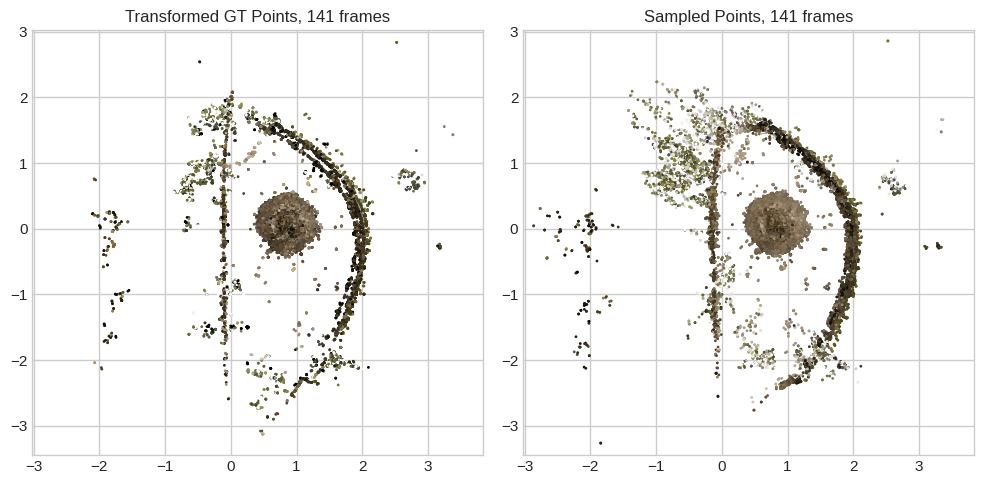

In [22]:
variance = np.var(pcd_xyz_sampled_array, axis=0)
ground_plane_indices = np.argsort(variance)[1:]

x_min = max(pcd_xyz_gt_array[:, ground_plane_indices[0]].min(), pcd_xyz_sampled_array[:, ground_plane_indices[0]].min())
x_max = min(pcd_xyz_gt_array[:, ground_plane_indices[0]].max(), pcd_xyz_sampled_array[:, ground_plane_indices[0]].max())
y_min = max(pcd_xyz_gt_array[:, ground_plane_indices[1]].min(), pcd_xyz_sampled_array[:, ground_plane_indices[1]].min())
y_max = min(pcd_xyz_gt_array[:, ground_plane_indices[1]].max(), pcd_xyz_sampled_array[:, ground_plane_indices[1]].max())

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pcd_xyz_gt_array[:, ground_plane_indices[0]], pcd_xyz_gt_array[:, ground_plane_indices[1]], c=pcd_rgb_gt_array, s=1)
plt.axis('equal')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(f"Transformed GT Points, {total_frame_num} frames")

plt.subplot(1, 2, 2)
plt.scatter(pcd_xyz_sampled_array[:, ground_plane_indices[0]], pcd_xyz_sampled_array[:, ground_plane_indices[1]], c=pcd_rgb_sampled_array, s=1)
plt.axis('equal')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(f"Sampled Points, {total_frame_num} frames")

plt.tight_layout()